In [2]:
import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import joblib
import pickle

from typing import List
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter("ignore")

In [3]:
# Import the dataframe and set random state
random_state = 9
df = pd.read_csv("Final_data_13_classes.csv")
df[" Label"].value_counts()

BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Web Attack             2143
Bot                    1948
Infiltration             36
Heartbleed               11
Name:  Label, dtype: int64

In [4]:
# Spliting the dataset  while making sure that each sample representitives of both Hearbleed and Infiltration
main_df, hold_df = train_test_split(df[(df[" Label"]!="Heartbleed") & 
                                       (df[" Label"]!="Infiltration")], test_size=0.01, random_state=random_state)
main_HB, hold_HB = train_test_split(df[df[" Label"]=="Heartbleed"], test_size=0.01, random_state=random_state)
main_In, hold_In = train_test_split(df[df[" Label"]=="Infiltration"], test_size=0.01, random_state=random_state)

# merge heartbleed and infiltration back into dataset
hold_df = pd.concat([hold_df, hold_HB, hold_In])

In [6]:
main_df[" Label"].value_counts()

BENIGN              2074067
DoS Hulk             171162
DDoS                 126716
PortScan              89788
DoS GoldenEye         10193
FTP-Patator            5869
DoS slowloris          5331
DoS Slowhttptest       5176
SSH-Patator            3197
Web Attack             2118
Bot                    1926
Name:  Label, dtype: int64

In [15]:
%%time

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format='%(asctime)s - %(levelname)s - %(message)s')

# Spliting the data into features and labels
X = main_df.drop(' Label', axis=1)
y = main_df[' Label']

# Spliting the dataset: 20% for the server, 80% for the clients
server_data, client_data = train_test_split(main_df, test_size=0.8, random_state=random_state, stratify=main_df[' Label'])
server_HB, client_HB = train_test_split(main_HB, test_size=0.8, random_state=random_state)
server_In, client_In = train_test_split(main_In, test_size=0.8, random_state=random_state)
# merge heartbleed and infiltration back into dataset
client_data = pd.concat([client_data, client_HB, client_In])

# Server's portion of the data
X_server = server_data.drop(' Label', axis=1)
y_server = server_data[' Label']#.values

X_HB_server = server_HB.drop(' Label', axis=1)
y_HB_server = server_HB[' Label']#.values

X_In_server = server_In.drop(' Label', axis=1)
y_In_server = server_In[' Label']


# Split server's data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_server, y_server, test_size=0.2,
                                                    random_state=random_state, stratify=y_server)
X_HB_train, X_HB_test, y_HB_train, y_HB_test = train_test_split(X_HB_server, y_HB_server, test_size=0.2,
                                                                random_state=random_state)
X_In_train, X_In_test, y_In_train, y_In_test = train_test_split(X_In_server, y_In_server, test_size=0.2,
                                                                random_state=random_state)
# merge heartbleed and infiltration back into dataset
X_train = pd.concat([X_train, X_HB_train, X_In_train])
X_test = pd.concat([X_test, X_HB_test, X_In_test])
y_train = pd.concat([y_train, y_HB_train, y_In_train])
y_test = pd.concat([y_test, y_HB_test, y_In_test])

# Standardise features between 0 and 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train model
initial_model = MLPClassifier(hidden_layer_sizes=(64, 128, 32), max_iter=10, random_state=random_state)
initial_model.fit(X_train, y_train)

# Evaluate the model to ensure it's trained
train_accuracy = initial_model.score(X_train, y_train)
test_accuracy = initial_model.score(X_test, y_test)

logging.info(f"Initial Model - Train Accuracy: {train_accuracy * 100:.2f}%")
logging.info(f"Initial Model - Test Accuracy: {test_accuracy * 100:.2f}%")

# Saving  the trained model to a file
joblib.dump(initial_model, 'initial_model_datasample3.pkl')
logging.info("Model saved to 'initial_model_datasample3.pkl'")

# Saving the test data to a file
joblib.dump((X_test, y_test), 'test_data_datasample3.pkl')
logging.info("Model and test data saved.")

C:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2024-09-03 22:48:57,672 - INFO - Initial Model - Train Accuracy: 97.77%
2024-09-03 22:48:57,673 - INFO - Initial Model - Test Accuracy: 97.72%
2024-09-03 22:48:57,675 - INFO - Model saved to 'initial_model_datasample3.pkl'
2024-09-03 22:48:57,690 - INFO - Model and test data saved.


CPU times: total: 1min 14s
Wall time: 22.8 s


In [16]:
logging.info(f"Initial Model - Train Accuracy: {train_accuracy * 100:.2f}%")
logging.info(f"Initial Model - Test Accuracy: {test_accuracy * 100:.2f}%")

2024-09-03 22:48:57,706 - INFO - Initial Model - Train Accuracy: 97.77%
2024-09-03 22:48:57,706 - INFO - Initial Model - Test Accuracy: 97.72%


In [6]:
# Checking Server's Data Distribution
server_series = pd.Series(y_server)
train_series = pd.Series(y_train)
test_series = pd.Series(y_test)

# Get value counts for each dataset
server_counts = server_series.value_counts()
train_counts = train_series.value_counts()
test_counts = test_series.value_counts()

# Combine the value counts into a DataFrame
distribution_df = pd.DataFrame({
    'Server Data': server_counts,
    'Training Data': train_counts,
    'Test Data': test_counts
}).fillna(0).astype(int)

distribution_df

Server Data  Training Data  Test Data
BENIGN                           414813         331850      82963
Bot                                 385            308         77
DDoS                              25343          20274       5069
DoS GoldenEye                      2039           1631        408
DoS Hulk                          34232          27386       6846
DoS Slowhttptest                   1035            828        207
DoS slowloris                      1066            853        213
FTP-Patator                        1174            939        235
Heartbleed                            0              1          1
Infiltration                          0              5          2
PortScan                          17958          14366       3592
SSH-Patator                         639            511        128
Web Attack � Brute Force            292            234         58
Web Attack � Sql Injection            4              3          1
Web Attack � XSS                    128            103         25

In [10]:
hold_df[" Label"].value_counts()

BENIGN                      20990
DoS Hulk                     1684
DDoS                         1298
PortScan                      906
DoS GoldenEye                  93
FTP-Patator                    62
DoS slowloris                  54
DoS Slowhttptest               52
Bot                            22
SSH-Patator                    22
Web Attack � Brute Force       13
Web Attack � XSS               12
Heartbleed                      1
Infiltration                    1
Name:  Label, dtype: int64

In [11]:
# evaluate our model using hold data
X_hserver = hold_df.drop(' Label', axis=1).values
y_hserver = hold_df[' Label'].values

X_hsserver = scaler.transform(X_hserver)
X_hsserverpred = initial_model.predict(X_hsserver)

hold_pred = accuracy_score(X_hsserverpred,y_hserver)
hold_pred

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


0.9790162633875447

##

# <code>Lets Evaluate the results of our initial model</code>

In [19]:
# get predictions 
y_pred = initial_model.predict(X_test)
y_prob = initial_model.predict_proba(X_test)

# print classification report
print(classification_report(y_test, y_pred))

# Calculating and printing accuracy, precision, recall, F1-score. Setting "zero_division=1" for those classes where non of the instances where predicted correclty
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Calculate loss, and rocauc
loss = initial_model.loss_
loss_log = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Loss: {loss}")
print(f"Logistic Loss: {loss_log}")
print(f"ROC AUC: {roc_auc}")

# Storing initial model's metrics for later

general_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Loss': loss,
    'Logistic Loss': loss_log,
    'ROC AUC': roc_auc
}

general_metrics_df = pd.DataFrame([general_metrics]).T
general_metrics_df.columns = ["Values"]
general_metrics_df.to_pickle("gen_met_init_model3.pkl")
general_metrics_df

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          BENIGN       0.98      0.99      0.99     82963
             Bot       0.90      0.34      0.49        77
            DDoS       0.99      0.98      0.98      5069
   DoS GoldenEye       0.97      0.96      0.97       408
        DoS Hulk       1.00      0.89      0.94      6846
DoS Slowhttptest       0.79      0.99      0.88       207
   DoS slowloris       0.89      0.60      0.71       213
     FTP-Patator       1.00      0.70      0.82       235
      Heartbleed       1.00      1.00      1.00         1
    Infiltration       0.00      0.00      0.00         2
        PortScan       0.86      0.87      0.86      3591
     SSH-Patator       1.00      0.86      0.92       128
      Web Attack       1.00      0.05      0.09        85

        accuracy                           0.98     99825
       macro avg       0.87      0.71      0.74     99825
    weighted avg       0.98      0.98      0.98     99825

Accuracy: 0

Values
Accuracy       0.977230
Precision      0.977431
Recall         0.977230
F1-Score       0.976468
Loss           0.062880
Logistic Loss  0.061861
ROC AUC        0.955274

##
## <code>Calculating metrics of :</code> 

**True Positive Rate (TPR)**: Also known as recall or sensitivity. $TPR = \frac{TP}{TP+FN}$
 
**False Positive Rate (FPR)**: $FPR = \frac{FP}{FP+TN}$

**True Negative Rate (TNR)** : $TNR = \frac {TN}{TN+FP}$

**False Negative Rate (FNR)** : $FNR = \frac {FN}{TP+FN}$

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Initialize lists to store TPR and FPR for each class
tpr_list = []
fpr_list = []

tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Calculate TPR and FPR for each class
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP 
    FP = np.sum(cm[:, i]) - TP 
    TN = np.sum(cm) - (TP + FP + FN)

    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    tpr_list.append(TPR)
    fpr_list.append(FPR)
    
    tp_list.append(TP)
    fp_list.append(FP)
    tn_list.append(TN)
    fn_list.append(FN)
    

# Convert lists to numpy arrays for easier manipulation if needed
tpr_array = np.array(tpr_list)
fpr_array = np.array(fpr_list)

tp_array = np.array(tp_list)
fp_array = np.array(fp_list)
tn_array = np.array(tn_list)
fn_array = np.array(fn_list)

# create attack classes metrics dataframe
attack_classes = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
                  'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 
                  'PortScan', 'SSH-Patator', 'Web Attack']

eval_metrics = pd.DataFrame({
    'Attack Class': attack_classes,
    'True Positive Rate (TPR)': tpr_list,
    'False Positive Rate (FPR)': fpr_list,
    'True Positive (TP)': tp_list,
    'False Positives (FP)': fp_list,
    'True Negatives (TN)': tn_list,
    'False Negatives (FN)': fn_list
})

# Set 'Attack Class' as the index
eval_metrics.set_index('Attack Class', inplace=True)

eval_metrics.to_pickle("eval_met_init_model3.pkl") # Saving the evaluation metrics of initial model into separate files
eval_metrics

True Positive Rate (TPR)  False Positive Rate (FPR)  \
Attack Class                                                            
BENIGN                            0.992394                   0.095481   
Bot                               0.337662                   0.000030   
DDoS                              0.978891                   0.000570   
DoS GoldenEye                     0.963235                   0.000111   
DoS Hulk                          0.893076                   0.000129   
DoS Slowhttptest                  0.990338                   0.000552   
DoS slowloris                     0.596244                   0.000161   
FTP-Patator                       0.697872                   0.000000   
Heartbleed                        1.000000                   0.000000   
Infiltration                      0.000000                   0.000000   
PortScan                          0.867168                   0.005320   
SSH-Patator                       0.859375                   0.000000   
Web Attack                        0.047059                   0.000000   

                  True Positive (TP)  False Positives (FP)  \
Attack Class                                                 
BENIGN                         82332                  1610   
Bot                               26                     3   
DDoS                            4962                    54   
DoS GoldenEye                    393                    11   
DoS Hulk                        6114                    12   
DoS Slowhttptest                 205                    55   
DoS slowloris                    127                    16   
FTP-Patator                      164                     0   
Heartbleed                         1                     0   
Infiltration                       0                     0   
PortScan                        3114                   512   
SSH-Patator                      110                     0   
Web Attack                         4                     0   

                  True Negatives (TN)  False Negatives (FN)  
Attack Class                                                 
BENIGN                          15252                   631  
Bot                             99745                    51  
DDoS                            94702                   107  
DoS GoldenEye                   99406                    15  
DoS Hulk                        92967                   732  
DoS Slowhttptest                99563                     2  
DoS slowloris                   99596                    86  
FTP-Patator                     99590                    71  
Heartbleed                      99824                     0  
Infiltration                    99823                     2  
PortScan                        95722                   477  
SSH-Patator                     99697                    18  
Web Attack                      99740                    81

In [21]:
print(initial_model)

MLPClassifier(hidden_layer_sizes=(64, 128, 32), max_iter=10, random_state=9)


In [22]:
default_params = initial_model.get_params()

# Print the default parameters
for param, value in default_params.items():
    print(f"{param}: {value}")

activation: relu
alpha: 0.0001
batch_size: auto
beta_1: 0.9
beta_2: 0.999
early_stopping: False
epsilon: 1e-08
hidden_layer_sizes: (64, 128, 32)
learning_rate: constant
learning_rate_init: 0.001
max_fun: 15000
max_iter: 10
momentum: 0.9
n_iter_no_change: 10
nesterovs_momentum: True
power_t: 0.5
random_state: 9
shuffle: True
solver: adam
tol: 0.0001
validation_fraction: 0.1
verbose: False
warm_start: False


##
## <code>Preparing Dataset for Clients (Cars)</code>

Dividing dataset of clietns into **20** stratified samples.

Making sure thath each all clients have same amount of data. Each client must have all of the representitives of <code>minor</code> classes, but should also have different representitives from <code>major</code> classes.

In [23]:
# Number of clients
n_clients = 20

# Shuffle the entire dataset
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled dataset into n_clients non-overlapping parts
split_size = len(df_shuffled) // n_clients
client_datasets = []

for i in range(n_clients):
    start_idx = i * split_size
    if i == n_clients - 1:  # Make sure the last client gets any remaining data
        end_idx = len(df_shuffled)
    else:
        end_idx = (i + 1) * split_size
    
    # Assign the split data to the client
    client_data = df_shuffled.iloc[start_idx:end_idx]
    client_datasets.append(client_data)

# Save each client's data to separate files (e.g., client1_data.pkl, etc.)
for i, client_data in enumerate(client_datasets, start=1):
    X_client = client_data.drop(' Label', axis=1).values
    y_client = client_data[' Label'].values
    joblib.dump((X_client, y_client), f'client{i}_data.pkl')

print("Data distribution across clients completed and saved.")


Data distribution across clients completed and saved.


In [29]:
# function to load and process data from pickle file with error handling
def load_and_process_data(client_data):
    # Check the type of data to understand its structure
    if isinstance(client_data, tuple) and len(client_data) == 2:
        X_train, y_train = client_data
        df = pd.DataFrame(X_train)
        df['Label'] = y_train 
    elif isinstance(client_data, pd.DataFrame):
        df = client_data
    else:
        raise ValueError("Unexpected data format. Please check the contents of the pickle file.")
    
    return df

# Creating dataframes from pickle files
client_data_1 = joblib.load('client19_data.pkl') #We can play with the file numbers to compare different dataframes
client_data_2 = joblib.load('client4_data.pkl')
df_1 = load_and_process_data(client_data_1)
df_2 = load_and_process_data(client_data_2)
df_1["Label"].value_counts()

BENIGN              104721
DoS Hulk              8577
DDoS                  6472
PortScan              4575
DoS GoldenEye          469
FTP-Patator            325
DoS slowloris          271
DoS Slowhttptest       238
SSH-Patator            178
Bot                    106
Web Attack             102
Infiltration             4
Heartbleed               1
Name: Label, dtype: int64

In [30]:
#Checking if the datasets are identical

are_equal = df_1.equals(df_2)
print("DataFrames are equal:", are_equal)

DataFrames are equal: False


In [35]:
#Creating a Dataframe to see each client's data distribution:

value_counts_1 = df_1["Label"].value_counts()
value_counts_2 = df_2["Label"].value_counts()
client_datasets = client_data[" Label"].value_counts()

combined_value_counts = pd.concat([value_counts_1, value_counts_2, client_datasets], axis=1)
combined_value_counts.columns = ['Client 1', 'Client 2', "All clients"]

combined_value_counts = combined_value_counts.fillna(0).astype(int) # in case some data are not presented in of of the clients

combined_value_counts

Client 1  Client 2  All clients
BENIGN              104721    104819       104747
DoS Hulk              8577      8719         8709
DDoS                  6472      6311         6562
PortScan              4575      4503         4362
DoS GoldenEye          469       511          505
FTP-Patator            325       280          292
DoS slowloris          271       296          248
DoS Slowhttptest       238       235          271
SSH-Patator            178       160          146
Bot                    106        93          105
Web Attack             102       107          108
Infiltration             4         4            2
Heartbleed               1         1            0

In [7]:
client_data

NameError: name 'client_data' is not defined

In [77]:
from scipy.spatial.distance import cdist
import joblib

# Load data for two clients
client_1_data = joblib.load('client1_data.pkl')
client_2_data = joblib.load('client2_data.pkl')

X_client_1, y_client_1 = client_1_data  # Extract features and labels for client 1
X_client_2, y_client_2 = client_2_data  # Extract features and labels for client 2

# Convert to DataFrames for easier handling
df_client_1 = pd.DataFrame(X_client_1)
df_client_2 = pd.DataFrame(X_client_2)

# Ensure both DataFrames have the same number of rows for comparison
min_rows = min(len(df_client_1), len(df_client_2))
df_client_1 = df_client_1.iloc[:min_rows]
df_client_2 = df_client_2.iloc[:min_rows]

# Calculate the pairwise distances between rows of client 1 and client 2
distances = cdist(df_client_1, df_client_2, metric='euclidean')

# Calculate the mean distance between corresponding rows
mean_distance = distances.diagonal().mean()

mean_distance

36260085.3000189

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


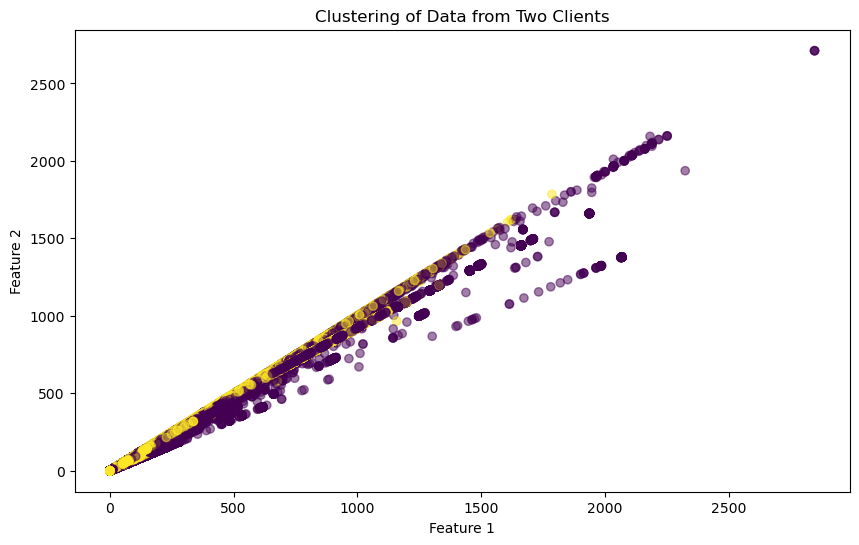

In [80]:
# Combine the data from two clients
combined_data = pd.concat([df_client_1, df_client_2])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(combined_data)

# Add cluster labels to the combined DataFrame
combined_data['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(combined_data.iloc[:, 0], combined_data.iloc[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Clustering of Data from Two Clients')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.savefig("Clustering of Data from Two Clients.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

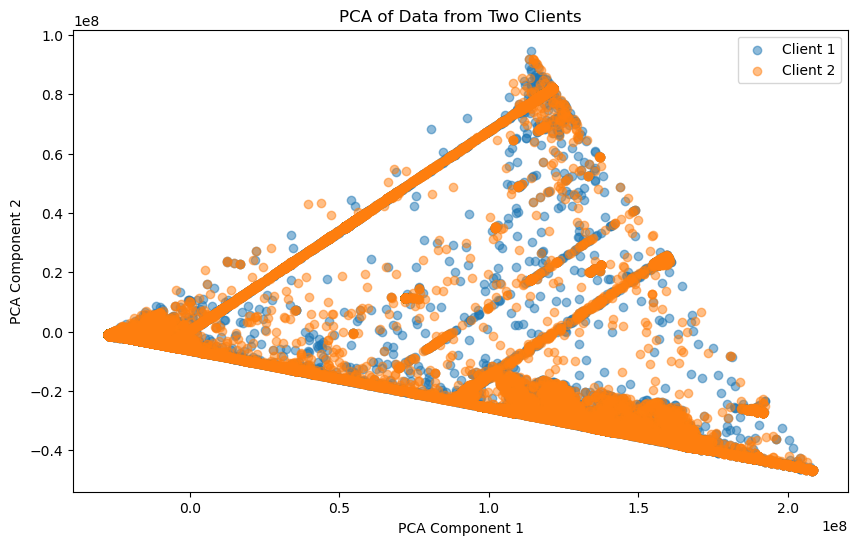

In [81]:
# Combine data and apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data.drop(columns=['Cluster']))

# Visualize the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:min_rows, 0], pca_result[:min_rows, 1], label='Client 1', alpha=0.5)
plt.scatter(pca_result[min_rows:, 0], pca_result[min_rows:, 1], label='Client 2', alpha=0.5)
plt.title('PCA of Data from Two Clients')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.savefig("PCA of Data from Two Clients.png", dpi=300, format='png', bbox_inches='tight')
plt.show()


#
## <code>Measuring the weight of the model</code>

In [34]:
# Measuring the size of the initial model
initial_model_size = os.path.getsize('initial_model_datasample3.pkl')
print(f"Model size: {initial_model_size} bytes")

Model size: 354467 bytes
